# Image Classification Notebook

## Table of Contents
  - [Image Classification Notebook](#Image-Classification-Notebook)
    - [References](#References)
    - [Libraries](#Libraries)
    - [Introduction](#Introduction)
    - [Classes](#Classes)
    - [Functions](#Functions)
    - [Dataset](#Dataset)
      - [Load data](#Load-data)
    - [Explore image processing](#Explore-image-processing)
      - [Geometric transformation](#Geometric-transformation)
        - [Scaling](#Scaling)
        - [Cropping](#Cropping)
        - [Vertical flip](#Vertical-flip)
        - [Horizontal flip](#Horizontal-flip)
        - [Rotation](#Rotation)
      - [Image filtering](#Image-filtering)
        - [Average filter](#Average-filter)
        - [Median filter](#Median-filter)
        - [Gaussian filter](#Gaussian-filter)
      - [Photometric transformation](#Photometric-transformation)
        - [Adjust brightness](#Adjust-brightness)
        - [Adjust contrast](#Adjust-contrast)
        - [Adjust saturation](#Adjust-saturation)
    - [CNN model development](#CNN-model-development)
      - [Data preprocessing](#Data-preprocessing)
        - [Data Augmentation](#Data-augmentation)
        - [Train, validation, and test sets](#Train-validation-and-test-sets)
        - [PyTorch datasets](#Pytorch-datasets)
        - [PyTorch dataloaders](#Pytorch-dataloaders)
      - [Model training](#Model-training)
        - [Training hyperparameters](#Training-hyperparameters)
        - [Initialise model architecture](#Initialise-model-architecture)
        - [Optimiser](#Optimiser)
        - [Train model](#Train-model)
        - [Loss function](#Loss-function)
      - [Learning curves](#Learning-curves)
      - [Model testing](#Model-testing)
      - [Explore results](#Explore-results)
        - [Compute average accuracy](#Compute-average-accuracy)
        - [Compute confusion matrix](#Compute-confusion-matrix)
      - [Explain image prediction](#Explain-image-prediction)
        - [Load data batch](#Load-data-batch)
        - [Compute GradCAM heatmap](#Compute-GradCAM-heatmap)
        - [Visualise GradCAM heatmap with the image](#Visualise-GradCAM-heatmap-with-the-image)


## Libraries

- NumPy
- Matplotlib
- Scikit-learn
- OpenCV-Python
- PyTorch
- Albumentations
- PyTorch GradCAM

In [47]:
# Important modules
import pytest
import os
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

## References

Here are some additional references to guide you while self-learning:
- Official documentation for [openCV](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html)
- Official documentation for [PIL library](https://pillow.readthedocs.io/en/stable/)
- Official documentation for [PyTorch](https://pytorch.org/)
- Official documentation for [Albumentations](https://albumentations.ai/)
- Official documentation for [PyTorch GradCAM](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html)
- [A tutorial from Microsoft to compute image classification using PyTorch](https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-train-model)

## Introduction

Image Classification is a foundational task in the field of computer vision and machine learning. This notebook aims to provide practical experience in image processing and in building and evaluating image classification models. It begins by demonstrating how to load and preprocess image data using Matplotlib and OpenCV-Python. Then, it shows how to build a basic image classification pipeline based on Convolutional Neural Networks (CNNs) using PyTorch, Albumentations, and Scikit-learn. Next, it covers how to evaluate model performance using Scikit-learn and NumPy, and finally, it introduces model explainability using Grad-CAM.

The goal of this notebook is not to teach the underlying algorithms and procedures used in this field, but rather to give the user an idea of what can be done with these Python libraries.

## Classes

The following three classes are essential for improving modularity and readability.

- **ImageDataset** is used to load images along with their labels and to perform image augmentation.
- **ImageClassifier** is responsible for building the image classification model, which in this case is based on Convolutional Neural Networks (CNNs).
- **Trainer** handles the training and evaluation processes using batches of data.

By organizing the code in this way, we simplify debugging and future extensions.


In [2]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
 
    def __len__(self):
        return len(self.images)
 
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
 
        # Ensure the image is in the shape (H, W, C) for Albumentations
        image = np.transpose(image, (1, 2, 0))
        
        # Apply Albumentations transforms
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label
    
class ImageClassifier(nn.Module):
    def __init__(self, in_channels=1, out_classes = 1):
        super(ImageClassifier, self).__init__()
        
        # Best model weights
        self.best_model_weights = None
        
        # Convolutional block layers
        self.feature_maps = 64
        
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels, self.feature_maps, kernel_size = 3)
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        self.bn1 = nn.BatchNorm2d(self.feature_maps)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(self.feature_maps, self.feature_maps * 2, kernel_size = 3)
        self.pool2 = nn.MaxPool2d(kernel_size = 2)
        self.bn2 = nn.BatchNorm2d(self.feature_maps * 2)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(self.feature_maps * 2, self.feature_maps * 4, kernel_size = 3)
        self.pool3 = nn.MaxPool2d(kernel_size = 2)
        self.bn3 = nn.BatchNorm2d(self.feature_maps * 4)
        
        # Rectified linear unit (activation function)
        self.relu = nn.ReLU()
        
        # Flatten layer that produces the features vector
        self.flatten = nn.Flatten(start_dim=1)
        
        # Dropout layer is responsible for introducing regularisation into training process
        self.dropout = nn.Dropout(p = 0.3)
        
        # Number of output classes
        self.out_classes = out_classes
        
        # Classification layer 
        self.fc = nn.Linear(1024, self.out_classes)
    
    def forward(self, x):
        # Convolutional block 1
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu(x)
        x = self.bn1(x)
        
        # Convolutional block 2
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu(x)
        x = self.bn2(x)
        
        # Convolutional block 3
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.relu(x)
        x = self.bn3(x)
        
        # Classifier
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class Trainer():
    def __init__(self, model):
        self.model = model
        self.train_losses = []
        self.val_losses = []
        
    def fit(self, epochs, train_dataloader, val_dataloader, optimizer, criterion, device, early_stopping_limit = 0):
        early_stopping_count = 0
        best_val_loss = 9999
        best_epoch = 0
        
        # Training log file
        log_filename = "training_log.txt"
        with open(log_filename, "w") as log_file:
            log_file.write("Epoch,Train Loss,Val Loss,Best Val Loss,Best Epoch\n")

        
        for epoch in range(epochs):
            # Train mode
            self.model.train()
            
            train_loss = 0.0
            train_samples_count = 0.0
            for i, data in enumerate(train_dataloader):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.long().to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward step
                outputs = self.model(inputs)
                
                # Backward step
                loss = criterion(outputs, labels)
                loss.backward()
                
                # Weight optimisation
                optimizer.step()

                train_loss += loss.item()
                train_samples_count += 1
                
            # Validation mode
            self.model.eval()
            
            val_loss = 0.0
            val_samples_count = 0.0
            for i, data in enumerate(val_dataloader):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.long().to(device)
                
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                val_samples_count += 1
            
            train_loss /= train_samples_count
            val_loss /= val_samples_count
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            
            early_stopping_count += 1
            
            if val_loss < best_val_loss:
                best_epoch = epoch
                best_val_loss = val_loss
                early_stopping_count = 0
                self.model.best_model_weights = self.model.state_dict()
            
                
            print(f'Epoch: {epoch}, Loss: {train_loss}, Val Loss: {val_loss}. The best val loss is {best_val_loss} in epoch {best_epoch}.')
            
            with open(log_filename, "a") as log_file:
                log_file.write(f"{epoch},{train_loss},{val_loss},{best_val_loss},{best_epoch}\n")
            
            if early_stopping_count == early_stopping_limit and early_stopping_limit > 0:
                break
    
    def predict(self, test_dataloader, device):
        # Load best weights
        if self.model.best_model_weights:
            self.model.load_state_dict(self.model.best_model_weights)

        # Test mode
        self.model.eval()
        
        original_images = []
        true_labels = []
        predicted_labels = []

        for data in test_dataloader:
            images, labels = data
            images = images.to(device)
            outputs = self.model(images)
            _, predicted = torch.max(outputs, 1)
            
            images = images.cpu().detach().numpy()
            labels = labels.numpy()
            predicted = predicted.cpu().detach().numpy()
            
            original_images.append(images)
            true_labels.append(labels)
            predicted_labels.append(predicted)
        
        original_images = np.concatenate(original_images)
        true_labels = np.concatenate(true_labels)
        predicted_labels = np.concatenate(predicted_labels)
        
        return original_images, true_labels, predicted_labels


## Functions

The following three functions are going to be used throughout the notebook. They comprise the loading of binary files using Pickle (**load_pickle_file**), single image plotting (**plot_image**), and multiple image plotting (**plot_multiple_images**).

In [3]:
def load_pickle_file(filepath):
    with open(filepath, "rb") as f:
        return pickle.load(f)

def plot_image(img, figsize = (2,3)):
    plt.figure(figsize = figsize)
    plt.imshow(img)
    plt.axis("off")
    
def plot_multiple_images(*images_titles, figsize = (2, 3)):
    num_images = len(images_titles)
    fig, axs = plt.subplots(1, num_images, figsize = figsize)
    for i in range(num_images):
        axs[i].imshow(images_titles[i][0])
        axs[i].set_title(images_titles[i][1])
        axs[i].axis("off")

## Dataset

In this section, we load the CIFAR-10 dataset, which consists of 60,000 32x32 color images across 10 different classes, with 6,000 images per class. The dataset is divided into 50,000 training images and 10,000 test images. It was already processed and it is ready to use after loading the binary files *train_set.pkl* and *test_set.pkl*.

### Load data

Training and test sets are loaded using Pickle library.

In [4]:
# Sets filepaths
dataset_folder = os.path.join("CIFAR10")
train_set_file = os.path.join(dataset_folder, "train_set.pkl")
test_set_file = os.path.join(dataset_folder, "test_set.pkl")

# Load sets
train_set = load_pickle_file(train_set_file)
test_set = load_pickle_file(test_set_file)

# CIFAR10 classes
CIFAR_10_CLASSES = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse","Ship","Truck"
]

## Explore image processing

Image processing is fundamental to computer vision, forming the basis for interpreting and analyzing visual information. By applying techniques such as resizing, filtering, color adjustments, and data augmentation, image processing enhances input quality, minimizes noise, and corrects distortions. These methods can also simulate real-world variability, helping models generalize better. In this notebook, we explore three categories of image transformations: geometric transformations, image filtering, and photometric transformations.

### Example image

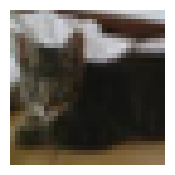

In [5]:
# Select image
image = train_set[0][9]

# Convert image from (C, H, W) to (H, W, C)
image = np.transpose(image, (1,2,0))

# Plot image
plot_image(image)

### Geometric transformation

Geometric transformations alter the spatial structure of the image while preserving its semantic content. They help the model become invariant to different orientations and scales:
- **Scaling**: Resizes the image to a specific size, often required to match input dimensions for image classifiers. It uses interpolation to obtain the new pixel-values.
- **Cropping**: Extracts a subregion of the image; useful for focusing on important parts or adding variability.
- **Horizontal and vertical flip**: Flips the image along the x-axis or y-axis; helps the model learn symmetry.
- **Rotation**: Rotates the image by a small angle to simulate different orientations of the objects.

#### Scaling

In [6]:
%reload_ext tutorial.tests.testsuite

In [7]:
%%ipytest

def solution_scale_image(img, scale_factor: float):
    # Get the current dimensions
    height, width = img.shape[:2]

    # Calculate the new dimensions
    new_width = int(width * scale_factor)
    new_height = int(height * scale_factor)
    new_size = (new_width, new_height)

    # Resize the image
    return cv2.resize(img, new_size)

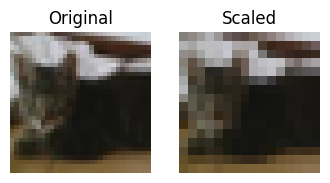

In [8]:
# Scale image by half
scaled_image = solution_scale_image(image, 0.5)

if scaled_image is not None:
    # Use this function to plot images side by side
    plot_multiple_images((image, "Original"), (scaled_image, "Scaled"), figsize = (4, 5))

#### Cropping

In [9]:
%%ipytest
def solution_crop_image(img, x: int, y: int, width: int, height: int):
    x1, x2, y1, y2 = x, x+width, y, y+height
    return img[y:y + height, x:x + width]

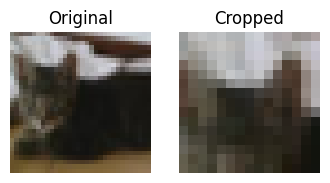

In [10]:
# Crop image to get a 15-by-15 image starting on (x,y): (2,2)
cropped_image = solution_crop_image(image, 2, 2, 15, 15)

if cropped_image is not None:
    # Use this function to plot images side by side
    plot_multiple_images((image, "Original"), (cropped_image, "Cropped"), figsize = (4, 5))

#### Horizontal Flip

In [11]:
%%ipytest
def solution_horizontal_flip_image(img):
    return cv2.flip(img, 1)

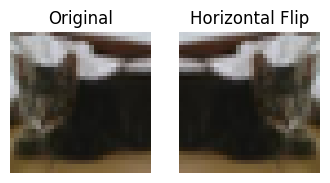

In [12]:
# Flip image horizontally
flip_image_horizontal = solution_horizontal_flip_image(image)

if flip_image_horizontal is not None:
    # Use this function to plot images side by side
    plot_multiple_images((image, "Original"), (flip_image_horizontal, "Horizontal Flip"), figsize = (4, 5))

#### Vertical Flip

In [13]:
%%ipytest
def solution_vertical_flip_image(img):
    return cv2.flip(img, 0)

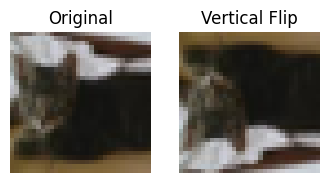

In [14]:
# Flip image vertically
flip_image_vertical = solution_vertical_flip_image(image)

if flip_image_vertical is not None:
    # Use this function to plot images side by side
    plot_multiple_images((image, "Original"), (flip_image_vertical, "Vertical Flip"), figsize = (4, 5))

#### Rotation

In [15]:
%%ipytest
def solution_rotate_image(img, angle: float):
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, scale=1.0)
    
    # Compute new bounding dimensions
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    # Adjust rotation matrix for translation
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]

    # Perform rotation with expanded canvas
    return cv2.warpAffine(img, M, (new_w, new_h))

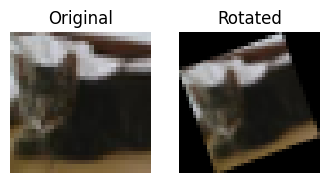

In [16]:
# Rotate image by 20 degrees
rotated_image = solution_rotate_image(image, 20)

if rotated_image is not None:
    # Use this function to plot images side by side
    plot_multiple_images((image, "Original"), (rotated_image, "Rotated"), figsize = (4, 5))

### Image filtering

Filtering helps reduce noise and enhance specific image features. These are often used as a form of preprocessing before feeding images into a model:
- **Average filter**: Applies a smoothing effect by replacing each pixel with the average of its neighborhood.
- **Median filter**: Reduces salt-and-pepper noise by replacing each pixel with the median of neighboring pixels.
- **Gaussian filter**: Applies a Gaussian blur to smooth the image, often used to reduce high-frequency noise.

#### Average filter 

In [17]:
%%ipytest
def solution_average_filter(img, kernel_size = (5, 5)):
    return cv2.blur(img, kernel_size)

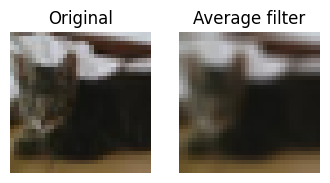

In [18]:
# Filter image using average filter
average_filter_image = solution_average_filter(image, (3, 3))

if average_filter_image is not None:
    # Use this function to plot images side by side
    plot_multiple_images((image, "Original"), (average_filter_image, "Average filter"), figsize = (4, 5))

#### Median filter

In [19]:
%%ipytest
def solution_median_filter(img, ksize):
    return cv2.medianBlur(img, ksize)

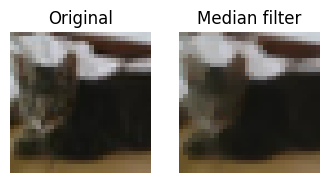

In [20]:
# Filter image using median filter
median_filter_image = solution_median_filter(image, 3)

if median_filter_image is not None:
    # Use this function to plot images side by side
    plot_multiple_images((image, "Original"), (median_filter_image, "Median filter"), figsize = (4, 5))

#### Gaussian filter

In [21]:
%%ipytest
def solution_gaussian_filter(img, kernel_size = (5, 5), sigma = 0):
    return cv2.GaussianBlur(img, kernel_size, sigma)

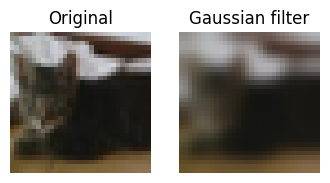

In [22]:
# Filter image using Gaussian filter
gaussian_filter_image = solution_gaussian_filter(image, (7, 7), 0)

if gaussian_filter_image is not None:
    # Use this function to plot images side by side
    plot_multiple_images((image, "Original"), (gaussian_filter_image, "Gaussian filter"), figsize = (4, 5))

### Photometric transformation

Photometric transformations modify the color properties of an image to simulate different lighting conditions and improve model robustness to brightness and contrast changes:
- **Brightness**: Randomly increases or decreases the brightness of the image.
- **Contrast**: Alters the difference between light and dark regions in the image.
- **Saturation**: Modifies the intensity of the colors in the image.

#### Adjust brightness

In [23]:
%%ipytest
def solution_adjust_brightness(img, brightness_value):
    return cv2.convertScaleAbs(img, beta=brightness_value)

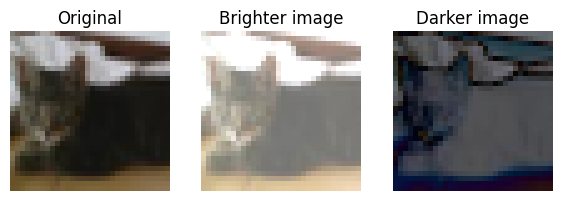

In [24]:
# Brighter image (positive brightness value)
brighter_image = solution_adjust_brightness(image, 100)

# Darker image (negative brightness value)
darker_image = solution_adjust_brightness(image, -100)

if brighter_image is not None and darker_image is not None:
    # Use this function to plot images side by side
    plot_multiple_images((image, "Original"), (brighter_image, "Brighter image"), (darker_image, "Darker image"), figsize = (7, 8))

#### Adjust contrast

In [25]:
%%ipytest
def solution_adjust_contrast(img, contrast_value):
    return cv2.convertScaleAbs(img, alpha = contrast_value)

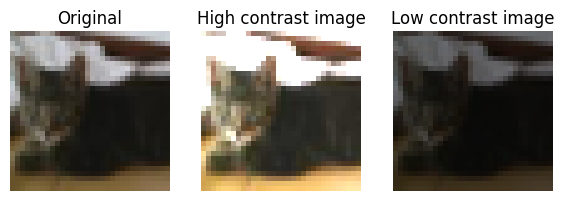

In [26]:
# Increase contrast (Value > 1.0)
high_contrast_image = solution_adjust_contrast(image, 2.0)

# Reduce contrast (Value < 1.0)
low_contrast_image = solution_adjust_contrast(image, 0.5)

if high_contrast_image is not None and low_contrast_image is not None:
    # Use this function to plot images side by side
    plot_multiple_images((image, "Original"), (high_contrast_image, "High contrast image"), (low_contrast_image, "Low contrast image"), figsize = (7, 8))

#### Adjust saturation

In [27]:
%%ipytest
def solution_adjust_saturation(img, saturation_factor):
    # Convert the image from BGR to HSV
    image_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Split the HSV image into Hue, Saturation, and Value channels
    hue, saturation, value = cv2.split(image_hsv)

    # Adjust the saturation channel (Ensure it stays within valid range)
    saturation = np.clip(saturation * saturation_factor, 0, 255)

    # Merge the channels back
    image_hsv_adjusted = cv2.merge([hue, saturation.astype(np.uint8), value])

    # Convert the adjusted image back to BGR
    return cv2.cvtColor(image_hsv_adjusted, cv2.COLOR_HSV2RGB)

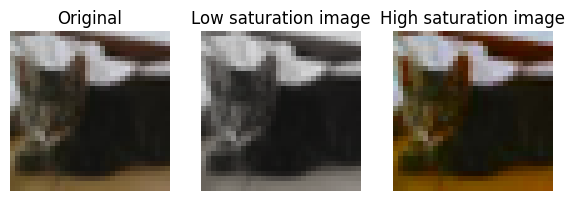

In [28]:
# Decrease saturation
low_saturation_image = solution_adjust_saturation(image, 0.2)

# Increase saturation
high_saturation_image = solution_adjust_saturation(image, 2.5)

if low_saturation_image is not None and high_saturation_image is not None:
    # Use this function to plot images side by side
    plot_multiple_images((image, "Original"), (low_saturation_image, "Low saturation image"), (high_saturation_image, "High saturation image"), figsize = (7, 8))

## Image classifier development using CNNs

Image classification is the task of assigning a label or category to an input image from a predefined set of classes. It is a fundamental problem in computer vision with widespread applications, including facial recognition, medical imaging, quality control, and autonomous driving. This section outlines the key steps involved in developing an image classification model using PyTorch. It begins with data preprocessing, which includes splitting the dataset into training, validation, and test sets. Afterwards, it defines data augmentation strategies using the Albumentations library, loads the data as PyTorch datasets, and initialises PyTorch dataloaders to efficiently feed data during training. The next step is model training, where a CNN-based model is initialized and optimised using the training and validation data. After training, the model is evaluated on the test set to assess its performance. The evaluation includes metrics such as accuracy and the confusion matrix, which help interpret the model's predictive behavior. Finally, the PyTorch Grad-CAM library is used to visualize the regions of input images that contribute most to the model’s decisions, providing insights into model explainability using representative examples.

### Dataset preprocessing

#### Train, validation, and test sets

```train_test_split``` from Scikit-learn can be used to split the original training set into training and validation sets. The test set is already defined by the dataset' authors.

In [29]:
# Train and validation sets
X_train, y_train = train_set[0], train_set[1]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

# Test set
X_test, y_test = test_set[0], test_set[1]

#### Data Augmentation

Data augmentation is a crucial technique in image classification that helps improve the performance and robustness of machine learning models. It involves generating new training samples by applying random transformations — such as rotation, flipping, cropping, scaling, or color jittering — to the original images. Albumentations is one of the most widely used libraries for performing data augmentation in image classification tasks. It includes augmentation techniques that replicate operations commonly used in image processing, such as:
- ```A.Affine``` for scaling;
- ```A.Rotate``` for rotation;
- ```A.HorizontalFlip``` for horizontal flipping;
- ```A.VerticalFlip``` for vertical flipping;
- ```A.ColorJitter``` for color jittering.

Albumentations can also be used for image normalization (```A.Normalize```), resizing (```A.Resize```), and converting images to PyTorch tensors with the (Channel, Height, Width) format using ```A.ToTensorV2```, which is required for model training.

In [30]:
TARGET_SIZE = 32

# Transformations performed on train set
train_transform = A.Compose([
    A.Affine(scale = (0.2, 1.5), p = 0.1),
    A.Rotate(limit = 45, p = 0.1),
    A.HorizontalFlip(p = 0.1),
    A.VerticalFlip(p = 0.1),
    A.ColorJitter(brightness = (0.5, 1.5), contrast = (0.5, 1.5), saturation = (0.5, 1.5), hue = (0,0), p = 0.1), # Applied only to 'image'
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616)), # Applied only to 'image'
    A.Resize(height = TARGET_SIZE, width = TARGET_SIZE),
    A.ToTensorV2()
])

# Transformations performed on validation and test sets
val_transform = A.Compose([
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616)), # Applied only to 'image'
    A.Resize(height = TARGET_SIZE, width = TARGET_SIZE),
    A.ToTensorV2()
])

#### PyTorch Datasets

```ImageDataset``` class is based on PyTorch ```Dataset``` class and is used for loading the images and their corresponding labels, for applying transformations (such as data augmentation), and returns them in a format suitable for model training, validating, and testing.

In [31]:
# Dataset classes necessary for the data loaders
train_dataset = ImageDataset(X_train, y_train, transform = train_transform)
val_dataset = ImageDataset(X_val, y_val, transform = val_transform)
test_dataset = ImageDataset(X_test, y_test, transform = val_transform)

#### PyTorch Dataloaders

```DataLoader``` is essential for training efficiency and performance. It abstracts the complexity of batching, shuffling, and parallel data access, allowing you to focus on building and training your models.

In [32]:
# Data loaders needed for the model training
train_dataloader = DataLoader(train_dataset, batch_size = 128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = 128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 128, shuffle=True)

### Model training

Model training comprises a series of steps. First, we must check which devices are available for training the model. In case a GPU with Cuda cores is available is should be used as it really improves the speed. Otherwise, lets use CPU. Then, model and training hyperparameters should be defined, such as numer of output classes, number of training epochs, number of consecutive not improving epochs needed for stopping the training in case we use early stopping regularisation, and learning rate. Other hyperparameters can be defined, it depends on what the user wants to do during the training. In this notebook we are going to define the number of epochs, which are the number of times the model is going to see the training set. Early stopping is a way of trying to avoid overfitting where the model evaluates the model every new epoch using a validation set. In case the loss obtained for the validation set does not decrease for a long period of time (pre-defined epochs), the model optimisation stops and retrieves the checkpoint where the validation loss got the last decrease (see [Early Stopping](https://paperswithcode.com/method/early-stopping)). Learning rate defined how quick the models weights should change during training. If it is too high the weights are going to change really quick and might miss minima because they are always jumping from one side to another side. If it is too small the model weights might get stuck a local minimum. So although this is not done in this notebook, this parameter should be studied in order to choose the best (see [What is learning rate in machine learning?](https://www.ibm.com/think/topics/learning-rate)). After defining the hyperparameters, we should define the loss function that is going to be used to evaluate the model and it should be sent to the hardware used for training. Afterwards, the model is defined using ```ImageClassifier``` class and is sent to the device used for training. Next, we should define the optimiser function and also send it to the device used for training. Afterwards, we train the model in case some optimised weights are not available and we explore the learning curves.

#### Check which device is used for training

In [33]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Define training hyperparameters

In [34]:
# Get number of output classes
NUMBER_CLASSES = len(CIFAR_10_CLASSES)

# Number of training epochs
EPOCHS = 500

# Number of consecutive not improving epochs needed for stopping the training
EARLY_STOPPING_LIMIT = EPOCHS // 10

# Learning rate
LR = 0.001

#### Loss function

The cross entropy loss function is defined by:

$$
\mathcal{L} = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$

Where:

$\mathcal{L}$: Cross-entropy loss

$C$: Total number of classes

$y_i$: Ground truth indicator for class $i$, where $y_i = 1$ if class $i$ is the correct class, otherwise $y_i = 0$

$\hat{y}_i$: Predicted probability for class $i$, typically from the softmax output, where $0 \leq \hat{y}_i \leq 1$ and $\sum_{i=1}^{C} \hat{y}_i = 1$

In [35]:
# Cross Entropy Loss
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(DEVICE)

#### Initialise model architecture

In [36]:
# Initialise image classifier
model = ImageClassifier(in_channels = 3, out_classes = NUMBER_CLASSES)
model = model.to(DEVICE)

#### Optimiser function

In this notebook, we are using Adam optimiser which is one of the most used optimisers in deep neural network optimisation (see [Gentle Introduction to the Adam Optimisation Algorithm for Deep Learning](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

The parameter update at each step is given by:

$$
\begin{aligned}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} \\
\theta_t &= \theta_{t-1} - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{aligned}
$$

Where:

$\theta_t$: Parameters at time step $t$

$g_t$: Gradient of the loss with respect to parameters at step $t$

$m_t$: Exponentially decaying average of past gradients (1st moment)

$v_t$: Exponentially decaying average of past squared gradients (2nd moment)

$\hat{m}_t$, $\hat{v}_t$: Bias-corrected estimates of $m_t$ and $v_t$

$\alpha$: Learning rate

$\beta_1$: Decay rate for the first moment estimate (typically 0.9)

$\beta_2$: Decay rate for the second moment estimate (typically 0.999)

$\epsilon$: Small constant to prevent division by zero (e.g., 1e-8)

In [37]:
# Adam Optimiser
optimizer = optim.Adam(model.parameters(), lr = LR)

#### Train model

Here, we train the model. First, we initialise the class ```Trainer``` which we are going to use for training and evaluating the model using the PyTorch ```Dataset```s defined before. In case, some model weights are already available, we can skip the training and using them.

In [38]:
# Train the image classifier
trainer = Trainer(model)
model_path = "cnn_weights.pt"

if os.path.exists(model_path):
    print("Loading model weights...")
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
else:
    print("Training model weights...")
    # Fit model
    trainer.fit(EPOCHS, train_dataloader, val_dataloader, optimizer, criterion, DEVICE, EARLY_STOPPING_LIMIT)
    # Save model weights
    torch.save(trainer.model.best_model_weights, "cnn_weights.pt")

Training model weights...
Epoch: 0, Loss: 1.520462845363756, Val Loss: 1.1197907672090046. The best val loss is 1.1197907672090046 in epoch 0.
Epoch: 1, Loss: 1.2096626140775473, Val Loss: 0.9215332592948008. The best val loss is 0.9215332592948008 in epoch 1.
Epoch: 2, Loss: 1.0686169616932417, Val Loss: 0.8447397245188891. The best val loss is 0.8447397245188891 in epoch 2.
Epoch: 3, Loss: 0.9770413578426751, Val Loss: 0.7714212577221757. The best val loss is 0.7714212577221757 in epoch 3.
Epoch: 4, Loss: 0.9027988477780001, Val Loss: 0.7413592813378673. The best val loss is 0.7413592813378673 in epoch 4.
Epoch: 5, Loss: 0.853520769925013, Val Loss: 0.7288939409841926. The best val loss is 0.7288939409841926 in epoch 5.
Epoch: 6, Loss: 0.8115674629263634, Val Loss: 0.7225121598122484. The best val loss is 0.7225121598122484 in epoch 6.
Epoch: 7, Loss: 0.7751083819970598, Val Loss: 0.6755026561223855. The best val loss is 0.6755026561223855 in epoch 7.
Epoch: 8, Loss: 0.74292450903976

#### Learning curves

After training the model, we can analyse the learning curves to assess the training process. These curves, which typically display the loss over epochs for both the training and validation sets, are crucial for improving model performance. They can help identify issues like overfitting or underfitting. Overfitting occurs when the model performs well on the training data but poorly on the validation data, usually indicated by a widening gap between the two curves. Underfitting, on the other hand, is suggested when both the training and validation curves show poor performance and fail to improve. By monitoring these curves, we can adjust hyperparameters or modify the model architecture to address such issues.

Text(0.5, 1.0, 'Learning curve of image classification model')

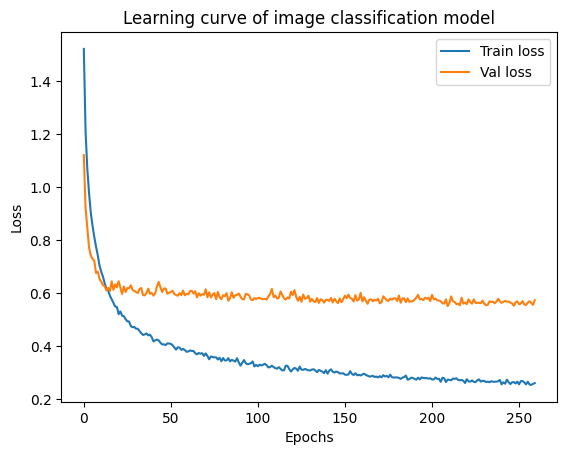

In [39]:
training_log = pd.read_csv("training_log.txt")

plt.figure()
plt.plot(training_log["Train Loss"])
plt.plot(training_log["Val Loss"])
plt.legend(["Train loss", "Val loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning curve of image classification model")

### Model testing

After having the model already optimised, we can evaluate the model using the ```Trainer``` class by calling the ```predict``` function.

In [40]:
original_images, true_labels, predicted_labels = trainer.predict(test_dataloader, DEVICE)

### Explore results

To evaluate the results, we display the model's accuracy along with the confusion matrix. The confusion matrix is a powerful evaluation tool that helps us understand the model’s performance across multiple classes. It maps the relationship between true and predicted labels, showing the number of instances for each possible prediction-outcome pair.

#### Compute average accuracy

In [41]:
# Compute average accuracy
num_test_samples = len(original_images)
correct = (true_labels == predicted_labels).sum()
print("Accuracy:", correct/num_test_samples)

Accuracy: 0.8303


#### Compute confusion matrix

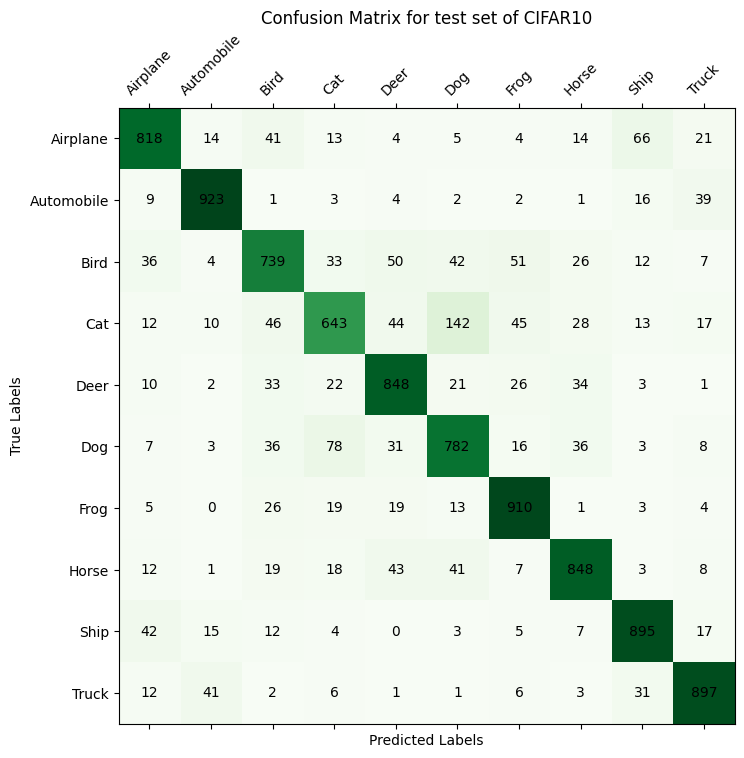

In [42]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(cm, cmap='Greens')

# Add labels, title, and ticks
ax.set_xticks(np.arange(NUMBER_CLASSES))
ax.set_yticks(np.arange(NUMBER_CLASSES))
ax.set_xticklabels(CIFAR_10_CLASSES)
ax.set_yticklabels(CIFAR_10_CLASSES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for test set of CIFAR10')

# Annotate each cell with the numeric value
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='black')

# Rotate class names on x-axis
plt.xticks(rotation=45)
plt.show()

### Explain image classifier predictions

Deep neural networks are often described as "black boxes" because their decision-making processes are difficult to understand and interpret. To address this, researchers have developed various methods to make these models more explainable. One such method is Grad-CAM (Gradient-weighted Class Activation Mapping). Grad-CAM computes the gradients of a target class with respect to the final convolutional layers and generates a heatmap that highlights the regions of the input image most influential in the model’s prediction for that class.

#### Prepare image for GradCAM

We begin by preparing the image for Grad-CAM visualisation. The image must be converted to the (Height, Width, Channels) format and normalized to values between 0 and 1, as the visualizer from the PyTorch-GradCAM library expects this format. Afterwards, a batch dimension should be added to make it compatible with the model's input requirements. We also retrieve the predicted and true labels, as both are needed for Grad-CAM computation and visualisation.

In [50]:
# Get a batch of images
idx = 1
img = original_images[idx]
img_np = np.transpose(img, (1,2,0)) # shape: (H, W, C)
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min()) # Should be normalised between 0 and 1
img = np.expand_dims(img, axis = 0)
img = torch.from_numpy(img)
img = img.to(DEVICE)  # shape: [1, C, H, W]
pred_label = predicted_labels[idx]
true_label = true_labels[idx]

#### Compute GradCAM heatmap

Using the predicted class, we compute the Grad-CAM values based on the activations and gradients from the last convolutional layer of the image classifier. This layer is typically chosen because it retains spatial information that helps localise the regions of the input image most relevant to the model's decision.

In [53]:
# Make sure input requires grad
img.requires_grad = True

# Define the layer(s) to inspect
target_layers = [model.conv3]

# Define the target class you want to explain
targets = [ClassifierOutputTarget(pred_label)]

# Make sure that the model is on eval and not on train mode
model.eval()

# Create CAM object
with GradCAM(model=model, target_layers=target_layers) as cam:
    grad_cam_matrix = cam(input_tensor=img, targets=targets)
    grad_cam_matrix = grad_cam_matrix[0, :]

#### Visualise GradCAM heatmap with the image

After obtaining the Grad-CAM heatmap, we overlay it on the input image to visualise the regions that contributed most to the model’s prediction. This helps identify which pixels the model focused on when predicting the class.

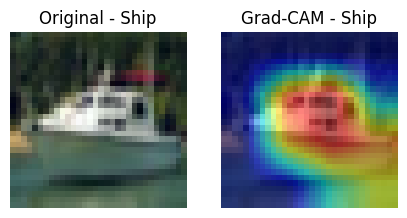

In [54]:
# Combine CAM with image
visualization = show_cam_on_image(img_np, grad_cam_matrix, use_rgb=True)

# Plot image with GradCAM output
true_class = CIFAR_10_CLASSES[true_label]
pred_class = CIFAR_10_CLASSES[pred_label]
plot_multiple_images((img_np, f"Original - {true_class}"), (visualization, f"Grad-CAM - {pred_class}"), figsize = (5,6))